## Table of contents
1. [Table of contents](#table-of-contents)
2. [Introduction](#Introduction)
3. [Authors](#Authors)
4. [Goal of this project](#goal-of-this-project)
5. [Implementation](#implementation)


## Introduction
This notebook
 is the authors' implementation for the group project developed during the [Database 2](https://en.didattica.unipd.it/off/2021/LM/IN/IN2547/004PD/INQ0091645/N0) course. Taught at the [Department of Information Engineering](https://www.unipd.it/en/dei) at the [University of Padova](https://www.unipd.it/en/) by professor [Gianmaria Silvello](mailto:silvello@dei.unipd.it)

## Authors
* [Aliia Sultanova](mailto:aliia.sultanova@studenti.unipd.it)
* [Michele Canale](mailto:michele.canale.1@studenti.unipd.it)
* [Odai Mohammad](mailto:odai.mohammad@studenti.unipd.it)
* [Yongxiang Ji](mailto:yongxiang.ji@studenti.unipd.it)

## Goal of this project
This project is aimed at modeling the transportation network in Italy. The data used is obtained from OpenStreetMap. This data can be obtained from Geofabrik's free download [server](https://download.geofabrik.de/index.html). Given that the data for the entire country is huge, we limit our data to a boundary containing the cities of Padova and Venice only.

## Implementation

Let's start by setting up our paths for reading the map data and saving the graph.

In [1]:
import os
from pathlib import Path

path = str(Path(os.path.abspath(os.getcwd())).absolute())

savePath =  path + '\\graph\\'

dataPath = path + '\\data\\padova-mestre-veneto.osm.pbf'

First let's load the data and build the OSM object

In [2]:
from pyrosm import OSM

osm = OSM(dataPath)

## Road network

PyrOSM provides the `get_network` API to read the road network.

Let's use it to get our road network represented as nodes and roads between them.

In [3]:
nodes, roads = osm.get_network(network_type='all', nodes=True)

Plotting the road network gives us a nice visualization of what we're working with.

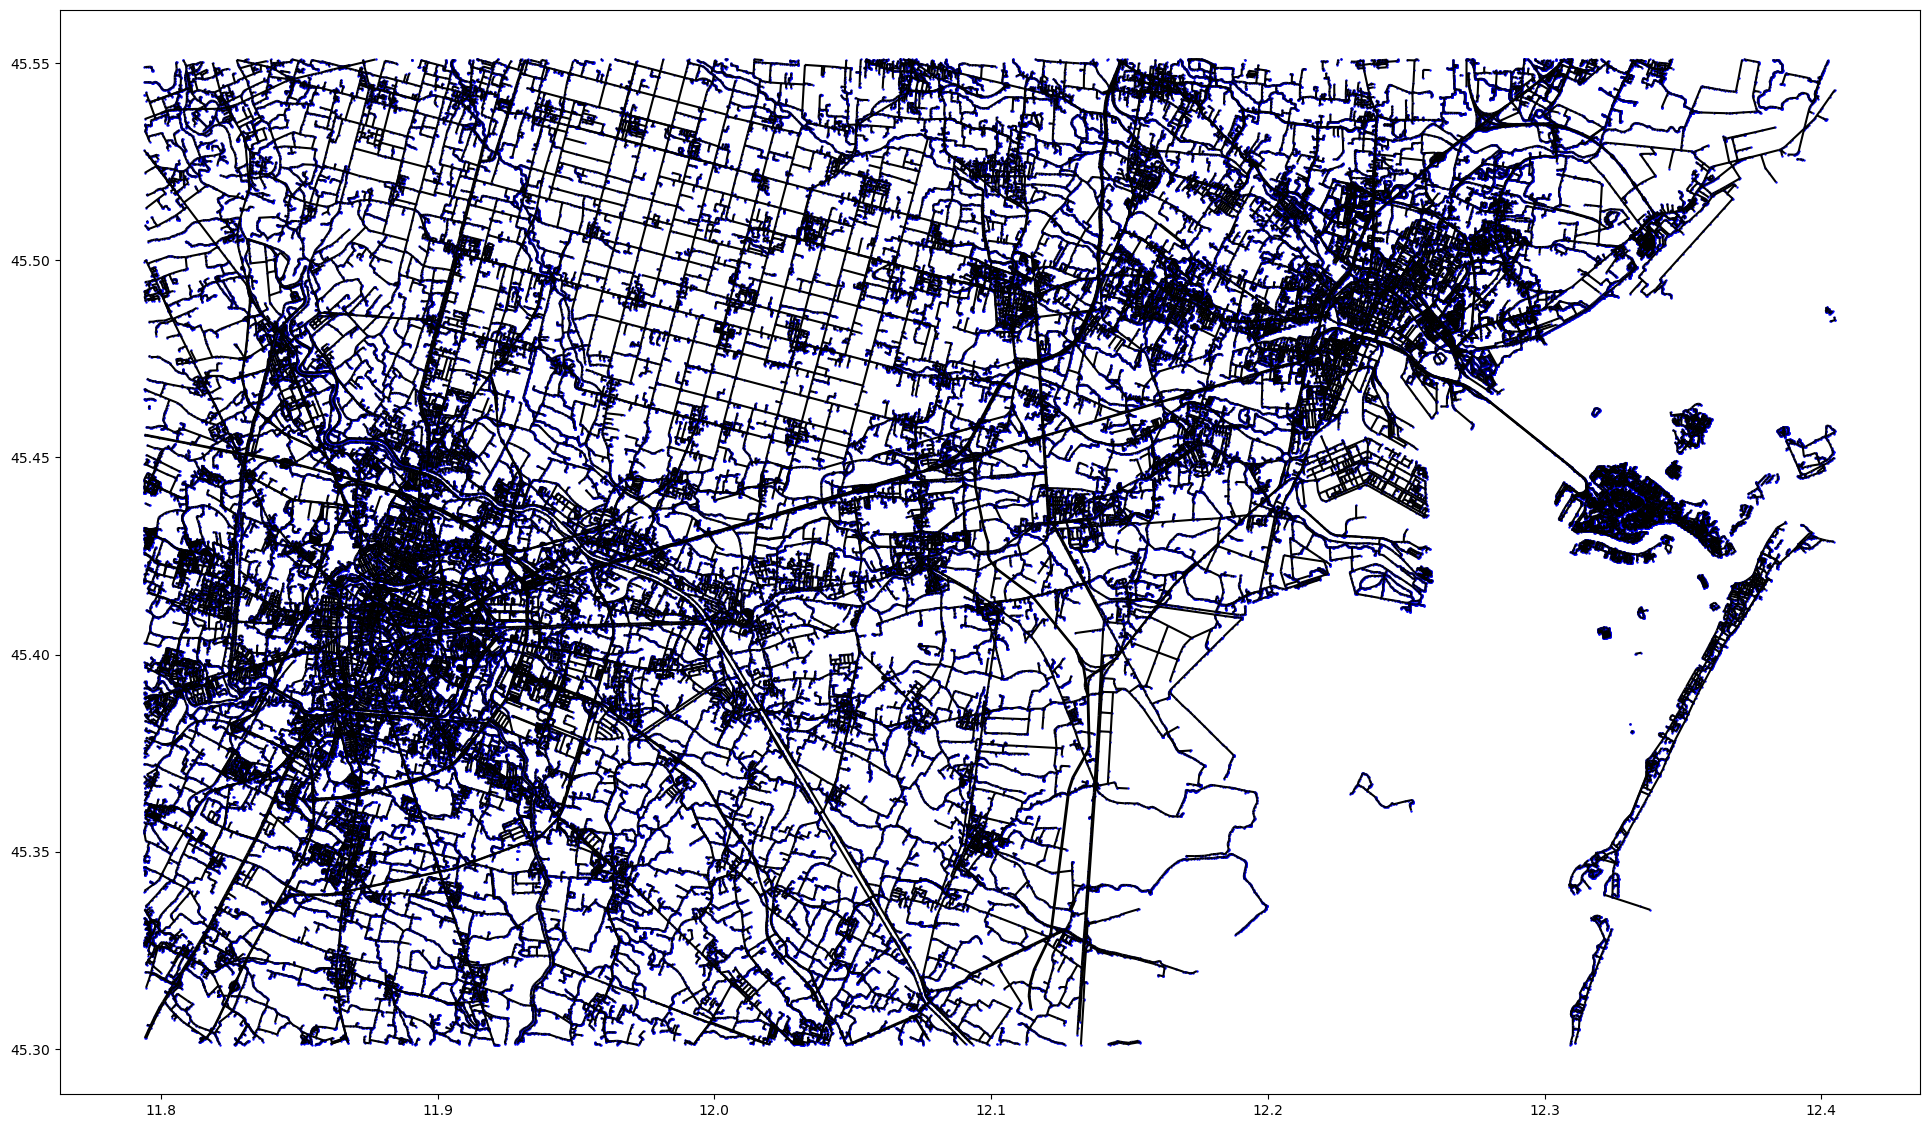

In [4]:
# Plot the road network on a map
ax = roads.plot(figsize=(24, 24), color="black")
ax = nodes.plot(ax=ax, color="blue", markersize=0.5)

### A closer look at the roads
Let's take a closer look at the roads' data. We can see that roads have many attributes that we can use.

In [5]:
roads.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 392863 entries, 0 to 392862
Data columns (total 43 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   access          15329 non-null   object  
 1   area            15548 non-null   object  
 2   bicycle         73487 non-null   object  
 3   bicycle_road    43 non-null      object  
 4   bridge          5547 non-null    object  
 5   busway          230 non-null     object  
 6   cycleway        2285 non-null    object  
 7   est_width       735 non-null     object  
 8   foot            43396 non-null   object  
 9   footway         23442 non-null   object  
 10  highway         392863 non-null  object  
 11  int_ref         1366 non-null    object  
 12  junction        17993 non-null   object  
 13  lanes           55730 non-null   object  
 14  lit             75760 non-null   object  
 15  maxspeed        33121 non-null   object  
 16  motorcar        702 non-null  

### A closer look at the nodes
How about the nodes' data? It's not as exciting as the roads' data, but it's essential to connect those roads together.

In [6]:
nodes.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 357998 entries, 0 to 357997
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype   
---  ------     --------------   -----   
 0   lon        357998 non-null  float64 
 1   lat        357998 non-null  float64 
 2   tags       28206 non-null   object  
 3   timestamp  357998 non-null  int8    
 4   version    357998 non-null  int8    
 5   changeset  357998 non-null  int8    
 6   id         357998 non-null  int64   
 7   geometry   357998 non-null  geometry
dtypes: float64(2), geometry(1), int64(1), int8(3), object(1)
memory usage: 14.7+ MB


### Inserting road network data into the graph

#### Inserting nodes' data

First we load the custom ontology that we've built

In [7]:
from rdflib import Graph, Literal, RDF, URIRef, Namespace, FOAF
from rdflib.namespace import XSD

OSMO = Namespace("http://www.dei.unipd.it/database2/cutomOSMOntology#")

Initialize the graph

In [8]:
g = Graph()

g.bind("xsd", XSD)
g.bind("osmo", OSMO)

Add the nodes to the graph

In [9]:
%%time
#measure execution time

for index, row in nodes.iterrows():
    # Create the node to add  to the Graph
    # the node has the namespace + the movie id as URI
    Node = URIRef(OSMO["node"+str(row['id'])])
    g.add((Node, RDF.type, OSMO.Node))
    g.add((Node, OSMO['hasId'], Literal(row['id'], datatype=XSD.integer)))
    g.add((Node, OSMO['hasLatitude'], Literal(row['lat'], datatype=XSD.decimal)))
    g.add((Node, OSMO['hasLongitude'], Literal(row['lon'], datatype=XSD.decimal)))

CPU times: total: 53.2 s
Wall time: 53.3 s


Write the nodes' data in turtle format

In [10]:
%%time
# print all the data in the Turtle format
print("--- saving serialization ---")
with open(savePath + 'nodes.ttl', 'wb') as file:
    file.write(g.serialize(format='turtle', encoding='utf-8'))

--- saving serialization ---
CPU times: total: 54.3 s
Wall time: 54.5 s


#### Inserting roads' data

First we group roads by id and aggregate lengths and nodes

In [11]:
roads_grouped = roads.groupby('id').agg({'name':'first',
                        'maxspeed':'first',
                        'lanes':'first',
                        'lit':'first',
                        'oneway':'first',
                        'surface':'first',
                        'overtaking':'first',
                        'bicycle_road':'first',
                        'footway':'first',
                        'motorroad':'first',
                        'busway':'first',
                             'length': sum,
                             'u': list,
                             'v': 'last' }).reset_index()

#### Initialize graph and insert roads

In [12]:
g = Graph()

g.bind("xsd", XSD)
g.bind("osmo", OSMO)

Now we can insert the roads and join them to their nodes

In [13]:
for index, row in roads_grouped.iterrows():
    # Create the node to add to the Graph
    # the node has the namespace + the movie id as URI
    Road = URIRef(OSMO["road"+str(row['id'])])

    for uindex, nodeId in enumerate(row['u']):
        Node = URIRef(OSMO["node"+str(nodeId)])

        if uindex == 0:
            g.add((Road, OSMO['hasStartNode'], Node))
        else:
            g.add((Road, OSMO['hasMiddleNode'], Node))

    endNode = URIRef(OSMO["node"+str(row['v'])])
    g.add((Road, OSMO['hasEndNode'], endNode))
    g.add((Road, RDF.type, OSMO.Road))
    g.add((Road, OSMO['hasId'], Literal(row['id'], datatype=XSD.integer)))
    g.add((Road, OSMO['hasName'], Literal(row['name'], datatype=XSD.string)))
    g.add((Road, OSMO['hasLength'], Literal(round(row['length'], 2), datatype=XSD.decimal)))
    g.add((Road, OSMO['hasMaxSpeed'], Literal(row['maxspeed'], datatype=XSD.string)))
    g.add((Road, OSMO['hasNumberOfLanes'], Literal(0 if row['lanes'] is None else row['lanes'], datatype=XSD.string)))
    g.add((Road, OSMO['hasSurface'], Literal(row['surface'], datatype=XSD.string)))
    g.add((Road, OSMO['isLit'], Literal(True if row['lit'] == 'yes' else False, datatype=XSD.boolean)))
    g.add((Road, OSMO['isOneWay'], Literal(True if row['oneway'] == 'yes' else False, datatype=XSD.boolean)))
    g.add((Road, OSMO['isOvertakingAllowed'], Literal(True if row['overtaking'] == 'yes' else False, datatype=XSD.boolean)))

Finally, let's write the roads data

In [14]:
%%time
# print all the data in the Turtle format
print("--- saving serialization ---")
with open(savePath + 'roads.ttl', 'wb') as file:
    file.write(g.serialize(format='turtle', encoding='utf-8'))

--- saving serialization ---
CPU times: total: 42.6 s
Wall time: 42.7 s


## Cities and Buildings

### Cities
OSM data doesn't have cities explicitly defined. But we can extract them from the addresses in the building's data.

PyrOSM provides the `get_buildings` API to read the buildings.

Let's use it to get our buildings and load them in the graph.

In [15]:
buildings = osm.get_buildings()

In [16]:
cities = buildings[buildings['addr:city'].notnull()]['addr:city'].unique()
cities = list(cities)

Inserting the cities into the graph.

First, initialize the graph.

In [17]:
g = Graph()

g.bind("xsd", XSD)
g.bind("osmo", OSMO)

Now insert the cities into the graph

In [18]:
%%time
#measure execution time

for index, city in enumerate(cities):
    # Create the node to add  to the Graph
    # the node has the namespace + the movie id as URI
    cityId = index+1001
    City = URIRef(OSMO["city"+str(cityId)])
    g.add((City, RDF.type, OSMO.City))
    g.add((City, OSMO['hasId'], Literal(cityId, datatype=XSD.integer)))
    g.add((City, OSMO['hasName'], Literal(city, datatype=XSD.string)))

CPU times: total: 0 ns
Wall time: 6 ms


Writing the cities data

In [19]:
%%time
# print all the data in the Turtle format
print("--- saving serialization ---")
with open(savePath + 'cities.ttl', 'wb') as file:
    file.write(g.serialize(format='turtle', encoding='utf-8'))

--- saving serialization ---
CPU times: total: 15.6 ms
Wall time: 14 ms


### Buildings

Let's bring our attention back to the buildings.

Plotting the buildings gives us a nice visualization of what we're working with.

<AxesSubplot: >

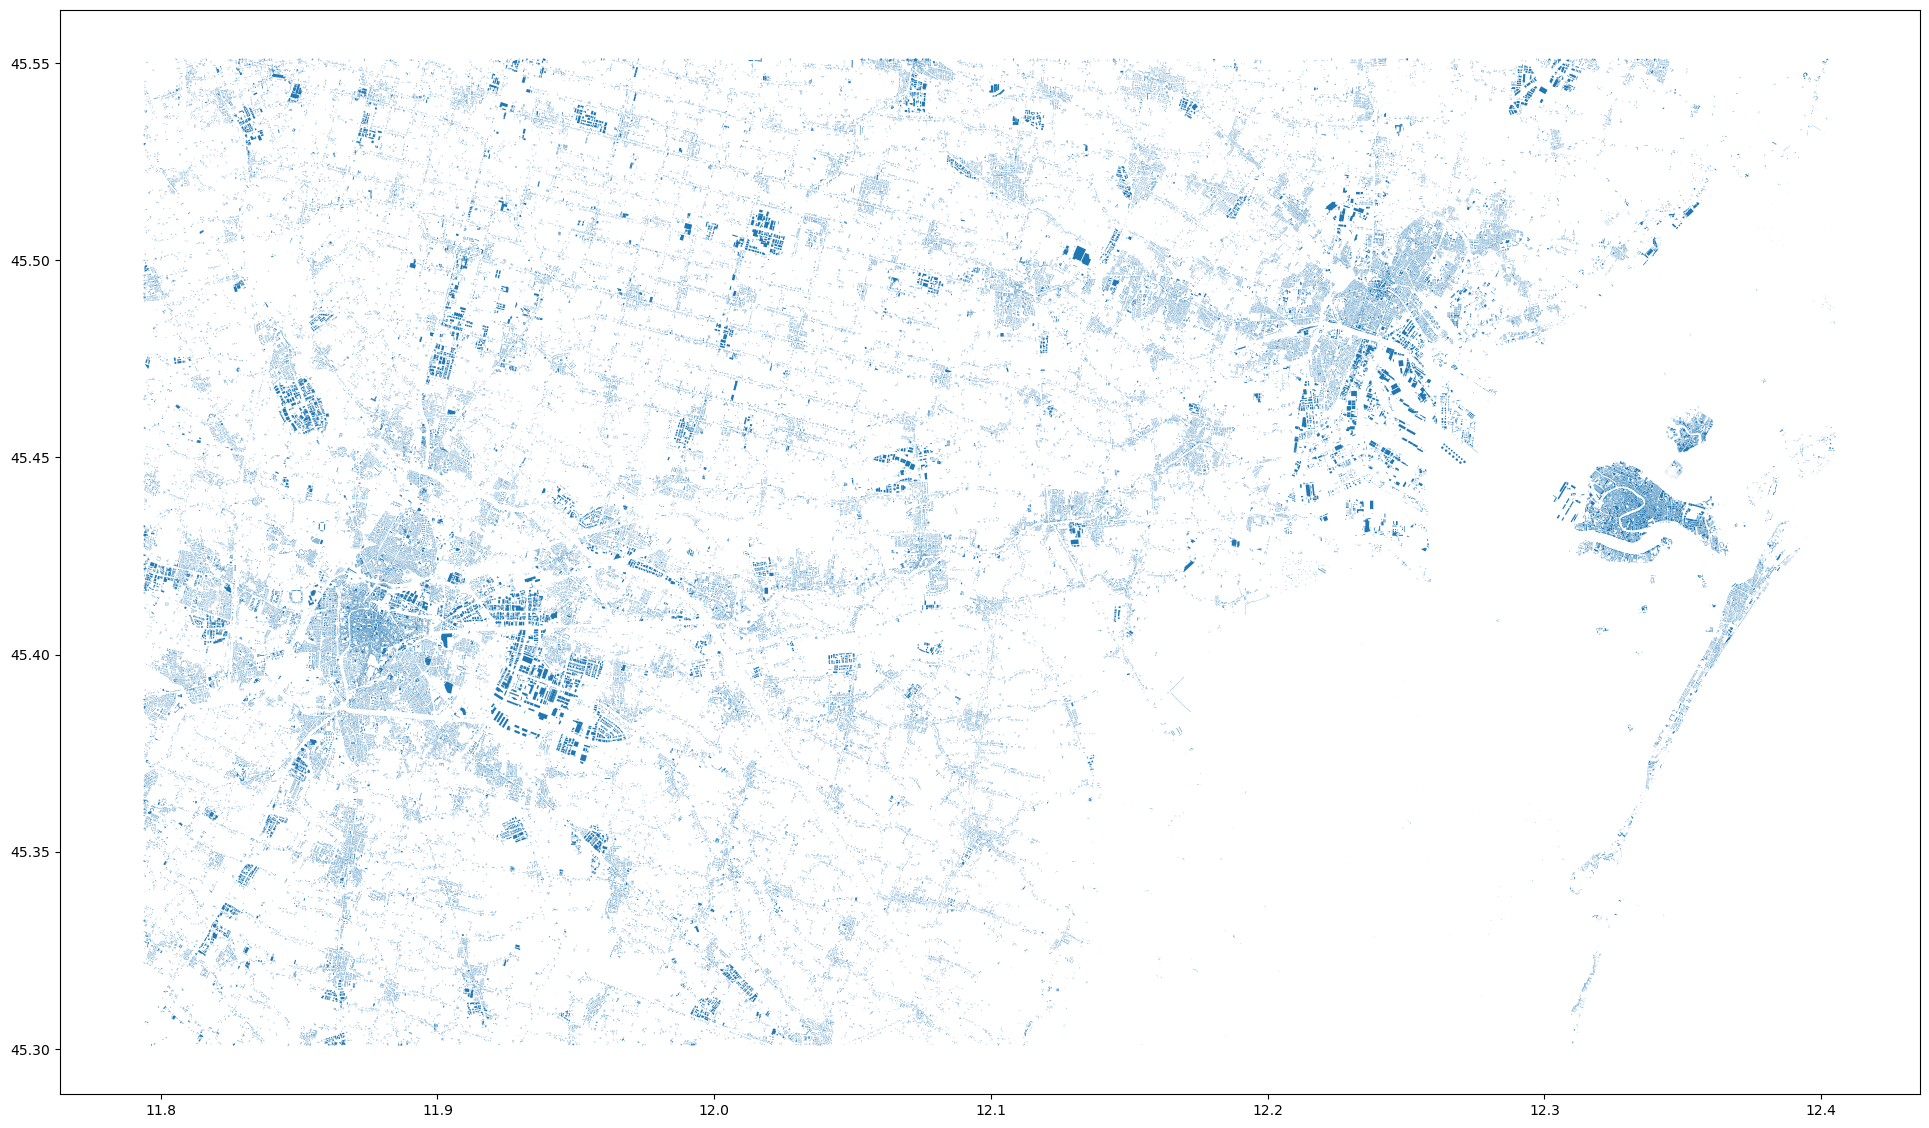

In [20]:
buildings.plot(figsize=(24,24))

### A closer look at the buildings
Let's take a closer look at the buildings' data. We can see that buildings have many attributes that we can use.

In [21]:
buildings.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 327402 entries, 0 to 327401
Data columns (total 39 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   addr:city           1260 non-null    object  
 1   addr:country        54 non-null      object  
 2   addr:housenumber    1656 non-null    object  
 3   addr:housename      39 non-null      object  
 4   addr:postcode       1396 non-null    object  
 5   addr:place          61 non-null      object  
 6   addr:street         1857 non-null    object  
 7   email               76 non-null      object  
 8   name                2262 non-null    object  
 9   opening_hours       103 non-null     object  
 10  operator            142 non-null     object  
 11  phone               158 non-null     object  
 12  ref                 6 non-null       object  
 13  url                 7 non-null       object  
 14  website             238 non-null     object  
 15  building 

### Inserting buildings data into the graph

First we remove unwanted buildings. Building without names are not useful for our queries. And shops and amenities will be inserted later.

In [22]:
buildings = buildings[buildings['name'].notnull()]
buildings = buildings[buildings['amenity'].isnull()]
buildings = buildings[buildings['shop'].isnull()]

Now we initialize the grapgh

In [23]:
g = Graph()

g.bind("xsd", XSD)
g.bind("osmo", OSMO)

Now we add the buildings to the graph. We also join buildings with cities in the process.

In [24]:
%%time
#measure execution time

for index, row in buildings.iterrows():
    # Create the node to add to the Graph
    # the node has 'building' + id as URI
    Building = URIRef(OSMO["building"+str(row['id'])])

    g.add((Building, RDF.type, OSMO.Building))
    g.add((Building, OSMO['hasId'], Literal(row['id'], datatype=XSD.integer)))
    g.add((Building, OSMO['hasName'], Literal(row['name'], datatype=XSD.string)))
    g.add((Building, OSMO['hasStreetName'], Literal(row['addr:street'], datatype=XSD.string)))
    g.add((Building, OSMO['hasCivilNumber'], Literal(row['addr:housenumber'], datatype=XSD.string)))
    g.add((Building, OSMO['hasPostCode'], Literal(row['addr:postcode'], datatype=XSD.integer)))
    g.add((Building, OSMO['hasOpeningHours'], Literal(row['opening_hours'], datatype=XSD.string)))
    g.add((Building, OSMO['hasEmail'], Literal(row['email'], datatype=XSD.string)))
    g.add((Building, OSMO['hasWebsite'], Literal(row['website'], datatype=XSD.string)))
    g.add((Building, OSMO['hasOperator'], Literal(row['operator'], datatype=XSD.string)))
    g.add((Building, OSMO['hasPhone'], Literal(row['phone'], datatype=XSD.string)))
    g.add((Building, OSMO['hasNUmberOfFlats'], Literal(row['building:flats'], datatype=XSD.string)))
    g.add((Building, OSMO['hasNUmberOfLevels'], Literal(row['building:levels'], datatype=XSD.string)))
    g.add((Building, OSMO['hasHeight'], Literal(row['height'], datatype=XSD.string)))
    g.add((Building, OSMO['hasUse'], Literal(row['height'], datatype=XSD.string)))

    try:
        City = URIRef(OSMO["city"+str(cities.index(row['addr:city']) + 1001)])
        g.add((Building, OSMO['buildingIsInCity'], City))
        road = roads_grouped[roads_grouped['name'] == row['addr:street']].iloc[0]
        Road = URIRef(OSMO["road"+str(road.id)])
        g.add((Building, OSMO['isOnRoad'], Road))
        g.add((Road, OSMO['roadIsInCity'], City))
    except:
        pass

CPU times: total: 1.03 s
Wall time: 1.05 s


Let's write the buildings data

In [25]:
%%time
# print all the data in the Turtle format
print("--- saving serialization ---")
with open(savePath + 'buildings.ttl', 'wb') as file:
    file.write(g.serialize(format='turtle', encoding='utf-8'))

--- saving serialization ---
CPU times: total: 766 ms
Wall time: 764 ms


## Points of Interest (pois)

PyrOSM provides the `get_pois` API to read the points of interests.

Let's use it to get our pois.

In [26]:
pois = osm.get_pois()

C:\Users\ASUS\anaconda3\envs\boring-wozniak\lib\site-packages\pyrosm\pyrosm.py:576: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  gdf = get_poi_data(


Plotting the pois gives us a nice visualization of what we're working with.

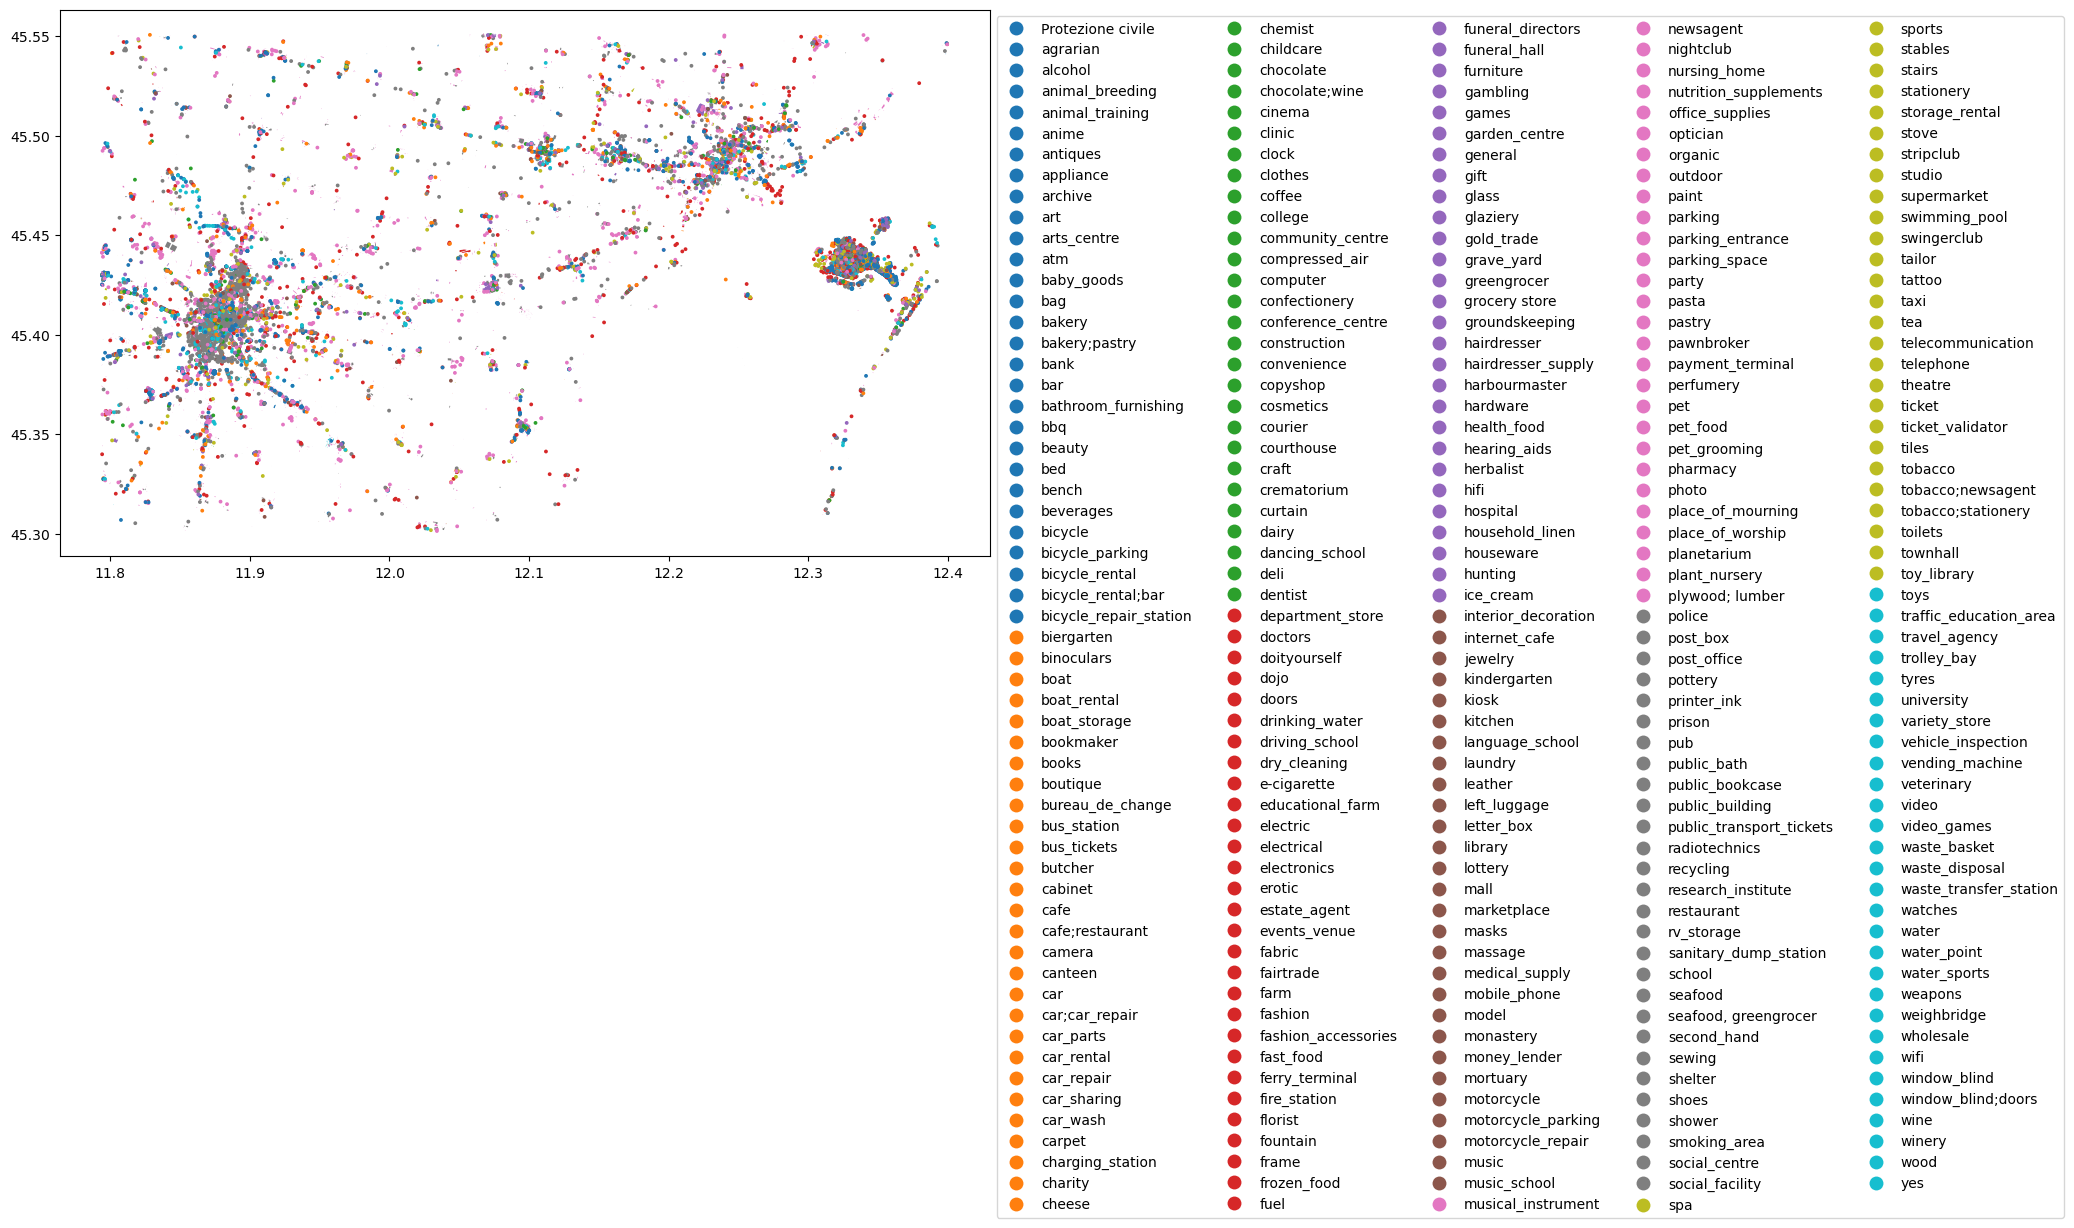

In [27]:
pois["poi_type"] = pois["amenity"]
pois["poi_type"] = pois["poi_type"].fillna(pois["shop"])

ax = pois.plot(column='poi_type', markersize=3, figsize=(12,12), legend=True, legend_kwds=dict(loc='upper left', ncol=5, bbox_to_anchor=(1, 1)))

### A closer look at the pois
Let's take a closer look at the pois data. We can see that pois have many attributes that we can use.

In [28]:
pois.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 21054 entries, 0 to 21053
Data columns (total 78 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   id                21054 non-null  int64   
 1   tags              10565 non-null  object  
 2   lon               12620 non-null  float32 
 3   changeset         12735 non-null  float64 
 4   timestamp         21054 non-null  int64   
 5   lat               12620 non-null  float32 
 6   version           21054 non-null  int8    
 7   addr:city         2448 non-null   object  
 8   addr:country      390 non-null    object  
 9   addr:housenumber  4073 non-null   object  
 10  addr:housename    28 non-null     object  
 11  addr:postcode     2918 non-null   object  
 12  addr:place        951 non-null    object  
 13  addr:street       3516 non-null   object  
 14  email             673 non-null    object  
 15  name              8103 non-null   object  
 16  opening_hours 

Now we can insert them into the RDF. We will use `get_pois` again to filter amenities from shops and insert them separately.

In [29]:
amenities = osm.get_pois(custom_filter={"amenity": True})
amenities = amenities[amenities['name'].notnull()]

C:\Users\ASUS\anaconda3\envs\boring-wozniak\lib\site-packages\pyrosm\pyrosm.py:576: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  gdf = get_poi_data(


Now we initialize the graph

In [30]:
# Create the graph
g = Graph()

# Bind the namespaces to a prefix
g.bind("xsd", XSD)
g.bind("osmo", OSMO)

In [31]:
%%time
#measure execution time

for index, row in amenities.iterrows():
    # Create the node to add to the Graph
    # the node has 'amenity' + id as URI
    Amenity = URIRef(OSMO["amenity"+str(row['id'])])

    g.add((Amenity, RDF.type, OSMO.Amenity))
    g.add((Amenity, OSMO['hasId'], Literal(row['id'], datatype=XSD.integer)))
    g.add((Amenity, OSMO['hasName'], Literal(row['name'], datatype=XSD.string)))
    g.add((Amenity, OSMO['hasStreetName'], Literal(row['addr:street'], datatype=XSD.string)))
    g.add((Amenity, OSMO['hasCivilNumber'], Literal(row['addr:housenumber'], datatype=XSD.string)))
    g.add((Amenity, OSMO['hasPostCode'], Literal(row['addr:postcode'], datatype=XSD.integer)))
    g.add((Amenity, OSMO['hasLatitude'], Literal(row['lat'], datatype=XSD.decimal)))
    g.add((Amenity, OSMO['hasLongitude'], Literal(row['lon'], datatype=XSD.decimal)))
    g.add((Amenity, OSMO['hasUse'], Literal(row['amenity'], datatype=XSD.string)))
    g.add((Amenity, OSMO['website'], Literal(row['website'], datatype=XSD.string)))

    try:
        City = URIRef(OSMO["city"+str(cities.index(row['addr:city']) + 1001)])
        g.add((Amenity, OSMO['amenityIsInCity'], City))
        road = roads_grouped[roads_grouped['name'] == row['addr:street']].iloc[0]
        Road = URIRef(OSMO["road"+str(road.id)])
        g.add((Amenity, OSMO['isOnRoad'], Road))
        g.add((Road, OSMO['roadIsInCity'], City))
    except:
        pass

CPU times: total: 3.41 s
Wall time: 3.47 s


Write the amenity data

In [32]:
%%time
# print all the data in the Turtle format
print("--- saving serialization ---")
with open(savePath + 'amenity.ttl', 'wb') as file:
    file.write(g.serialize(format='turtle', encoding='utf-8'))

--- saving serialization ---
CPU times: total: 1.86 s
Wall time: 1.86 s


We repeat the steps for the shops data

In [33]:
# Create the graph
g = Graph()

# Bind the namespaces to a prefix
g.bind("xsd", XSD)
g.bind("osmo", OSMO)

In [34]:
# Filter shops
shops = osm.get_pois(custom_filter={"shop": True})
shops = shops[shops['name'].notnull()]
shops.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2289 entries, 0 to 3006
Data columns (total 39 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   id                2289 non-null   int64   
 1   tags              1158 non-null   object  
 2   lon               2101 non-null   float32 
 3   changeset         2106 non-null   float64 
 4   timestamp         2289 non-null   int64   
 5   lat               2101 non-null   float32 
 6   version           2289 non-null   int8    
 7   addr:city         909 non-null    object  
 8   addr:country      109 non-null    object  
 9   addr:housenumber  1350 non-null   object  
 10  addr:housename    4 non-null      object  
 11  addr:postcode     919 non-null    object  
 12  addr:place        209 non-null    object  
 13  addr:street       1226 non-null   object  
 14  email             231 non-null    object  
 15  name              2289 non-null   object  
 16  opening_hours   

C:\Users\ASUS\anaconda3\envs\boring-wozniak\lib\site-packages\pyrosm\pyrosm.py:576: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  gdf = get_poi_data(


In [35]:
%%time
#measure execution time

for index, row in shops.iterrows():
    # Create the node to add to the Graph
    # the node has 'shop' + id as URI
    Shop = URIRef(OSMO["shop"+str(row['id'])])

    g.add((Shop, RDF.type, OSMO.Node))
    g.add((Shop, OSMO['hasId'], Literal(row['id'], datatype=XSD.integer)))
    g.add((Shop, OSMO['hasName'], Literal(row['name'], datatype=XSD.string)))
    g.add((Shop, OSMO['hasStreetName'], Literal(row['addr:street'], datatype=XSD.string)))
    g.add((Shop, OSMO['hasCivilNumber'], Literal(row['addr:housenumber'], datatype=XSD.string)))
    g.add((Shop, OSMO['hasPostCode'], Literal(row['addr:postcode'], datatype=XSD.integer)))
    g.add((Shop, OSMO['hasLatitude'], Literal(row['lat'], datatype=XSD.decimal)))
    g.add((Shop, OSMO['hasLongitude'], Literal(row['lon'], datatype=XSD.decimal)))
    g.add((Shop, OSMO['hasUse'], Literal(row['shop'], datatype=XSD.string)))
    g.add((Shop, OSMO['website'], Literal(row['website'], datatype=XSD.string)))

    try:
        City = URIRef(OSMO["city"+str(cities.index(row['addr:city']) + 1001)])
        g.add((Shop, OSMO['shopIsInCity'], City))
        road = roads_grouped[roads_grouped['name'] == row['addr:street']].iloc[0]
        Road = URIRef(OSMO["road"+str(road.id)])
        g.add((Shop, OSMO['isOnRoad'], Road))
        g.add((Road, OSMO['roadIsInCity'], City))
    except:
        pass

CPU times: total: 2.08 s
Wall time: 2.09 s


In [36]:
%%time
# print all the data in the Turtle format
print("--- saving serialization ---")
with open(savePath + 'shop.ttl', 'wb') as file:
    file.write(g.serialize(format='turtle', encoding='utf-8'))

--- saving serialization ---
CPU times: total: 828 ms
Wall time: 837 ms
